### Quest: Can you accurately predict insurance costs?

#### Data: Kaggle- [Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

#import warnings
#warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

In [2]:
DF_data = pd.read_csv('insurance.csv')
print(DF_data.shape)
print(DF_data.keys())
print(DF_data.dtypes)

(1338, 7)
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [3]:
DF_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
DF_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
print('Missing Training Data:')
DF_data.isnull().sum() # count number of missing frames for each column

Missing Training Data:


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

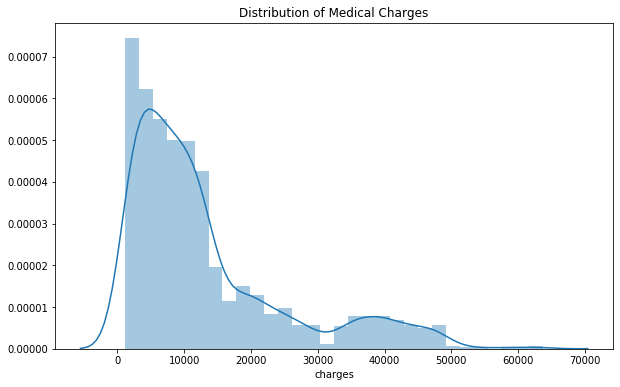

In [6]:
plt.figure(figsize=(10,6))
ax = sns.distplot(DF_data['charges'])
ax.set_title('Distribution of Medical Charges');

(Dependent variable) medical charges seem to be pretty heavily skewed

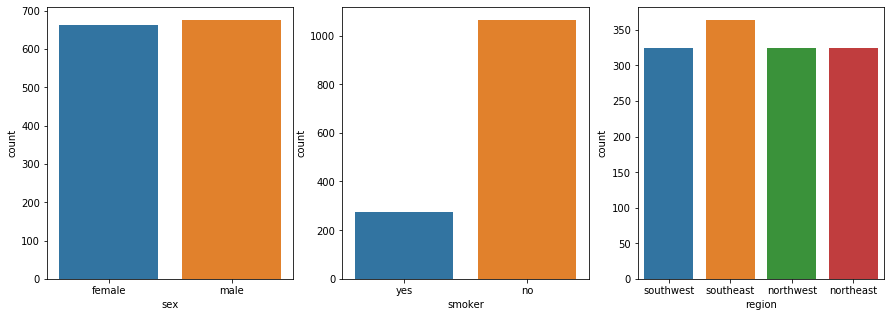

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.countplot(DF_data.sex);
plt.subplot(1,3,2)
sns.countplot(DF_data.smoker);
plt.subplot(1,3,3)
sns.countplot(DF_data.region);

categorical variables (independent variables) need encode later

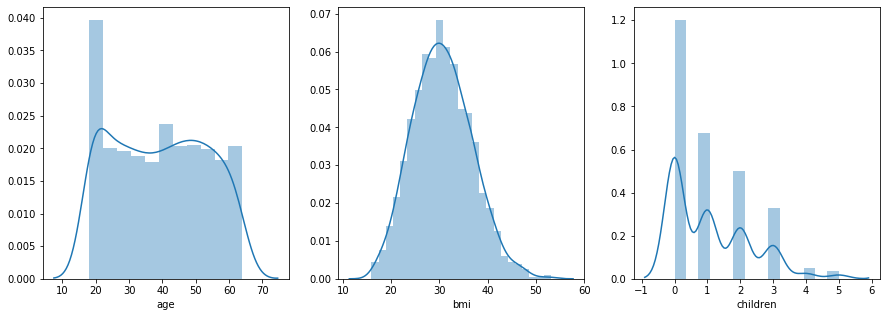

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.distplot(DF_data.age);
plt.subplot(1,3,2)
sns.distplot(DF_data.bmi);
plt.subplot(1,3,3)
sns.distplot(DF_data.children);

distributions of the numeric dependant variables:
<br />
Pretty even distribution of ages (aside from the youngest group being higher.) BMI is pretty normally distibuted, but the population is Obese (BMI >30), on average

#### Let's Explore How the Independant Variables Influence Medical Cost

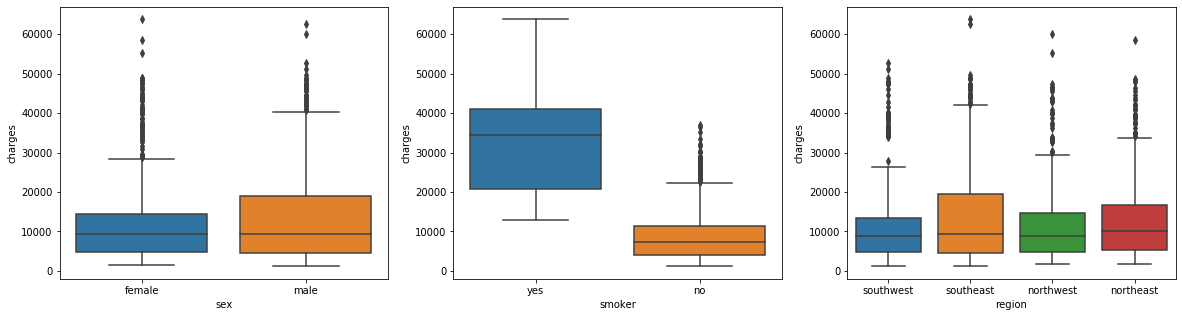

In [9]:
# First See if charges differ within the categorical variables...
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(x='sex',y='charges',data=DF_data)
plt.subplot(1,3,2)
sns.boxplot(x='smoker',y='charges',data=DF_data)
plt.subplot(1,3,3)
sns.boxplot(x='region',y='charges',data=DF_data);

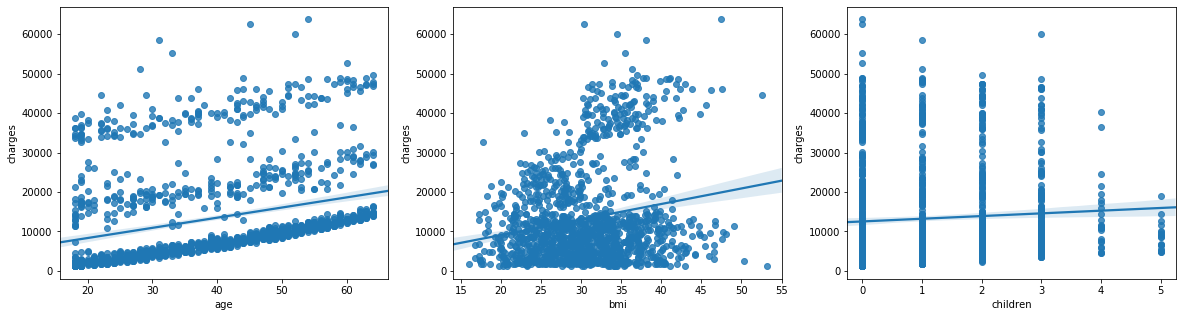

In [10]:
# Next let's try the non-categorical data:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.regplot(x='age',y='charges',data=DF_data)
plt.subplot(1,3,2)
sns.regplot(x='bmi',y='charges',data=DF_data)
plt.subplot(1,3,3)
sns.regplot(x='children',y='charges',data=DF_data);

it looks like Smoking has a pretty huge impact on medical charges. Age and BMI can also have an effect. Next, let's see how these variables relate to eachother, as well as to charges.

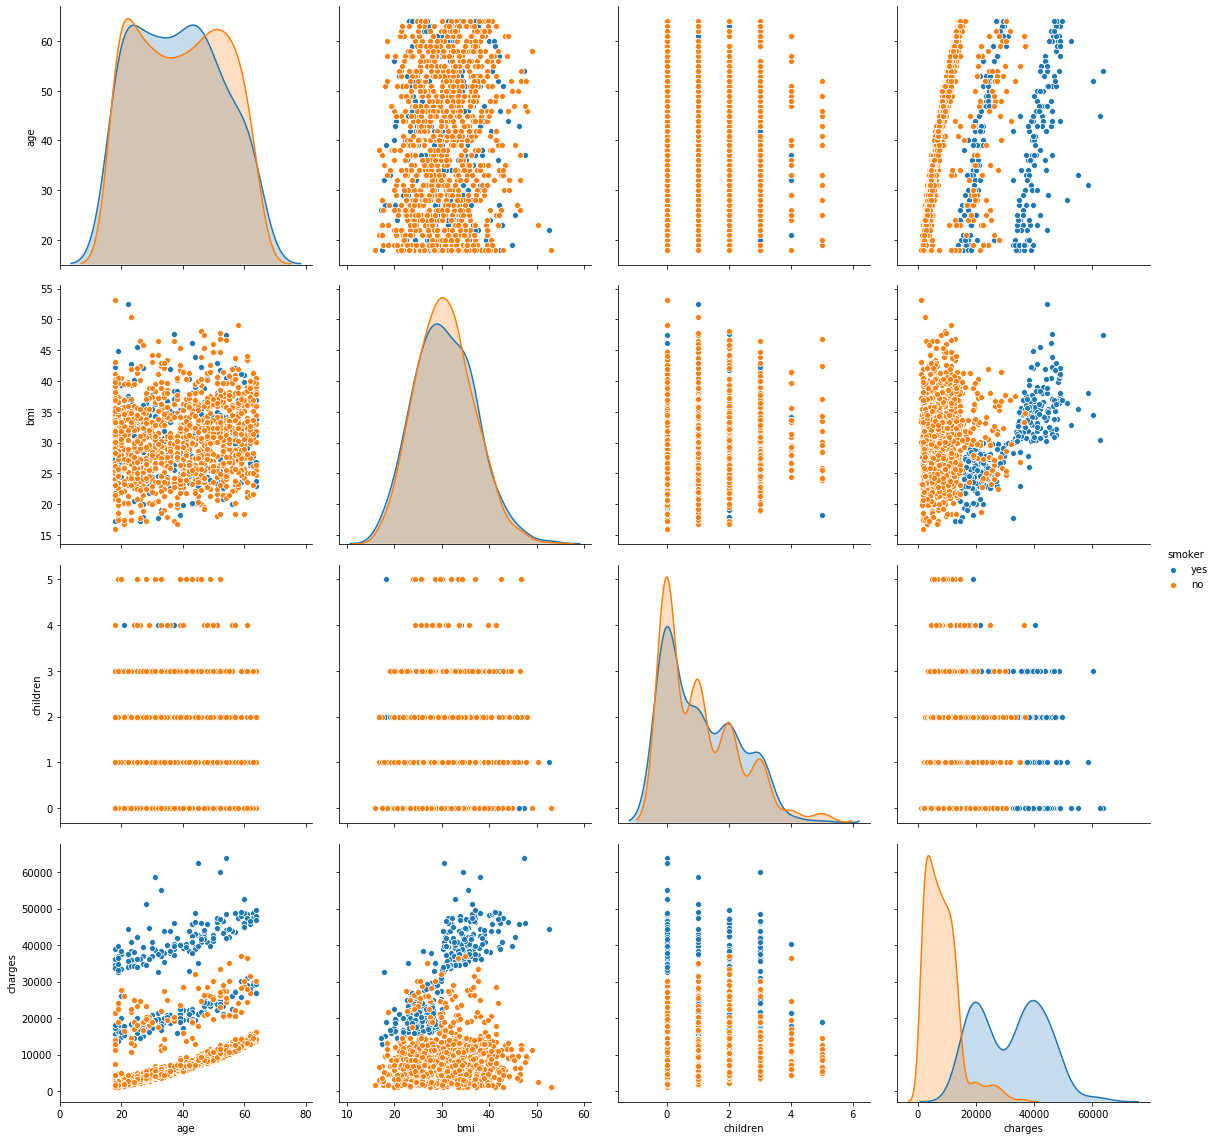

In [11]:
g = sns.pairplot(DF_data, hue='smoker', height=4)

#### Feature Engineering

In [12]:
# For sex... Lets Change 'Female' to 0 and 'Male' to 1
DF_data.loc[DF_data['sex'] == 'male', 'sex'] = 0
DF_data.loc[DF_data['sex'] == 'female', 'sex'] = 1

# For smoker... Lets Change 'no' to 0 and 'yes' to 1
DF_data.loc[DF_data['smoker'] == 'no', 'smoker'] = 0
DF_data.loc[DF_data['smoker'] == 'yes', 'smoker'] = 1

# For region... Lets Change to 1:4
DF_data.loc[DF_data['region'] == 'southwest', 'region'] = 0
DF_data.loc[DF_data['region'] == 'southeast', 'region'] = 1
DF_data.loc[DF_data['region'] == 'northwest', 'region'] = 2
DF_data.loc[DF_data['region'] == 'northeast', 'region'] = 3

In [13]:
DF_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


In [14]:
# Add weight classifications based on BMI
# underweight <18 , normal = 18-25, overweight = 25-30, obese= >30

DF_data.loc[DF_data['bmi'] < 18, 'weightclass'] = 0 #Underweight
DF_data.loc[(DF_data['bmi'] >= 18) & (DF_data['bmi'] < 25), 'weightclass'] = 1 # Normal Weight
DF_data.loc[(DF_data['bmi'] >= 25) & (DF_data['bmi'] < 30), 'weightclass'] = 2 #overweight
DF_data.loc[DF_data['bmi'] >= 30, 'weightclass'] = 4 # Obese

DF_data.head()

,age,sex,bmi,children,smoker,region,charges,weightclass
0,19,1,27.900,0,1,0,16884.92400,2.0
1,18,0,33.770,1,0,1,1725.55230,4.0
2,28,0,33.000,3,0,1,4449.46200,4.0
3,33,0,22.705,0,0,2,21984.47061,1.0
4,32,0,28.880,0,0,2,3866.85520,2.0


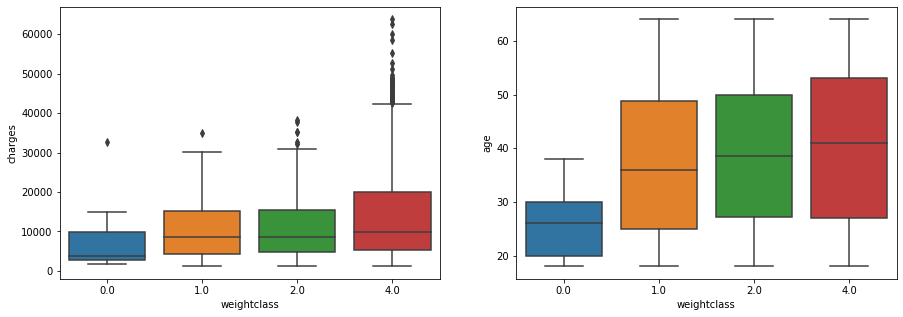

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x='weightclass',y='charges',data=DF_data);
plt.subplot(1,2,2)
sns.boxplot(x='weightclass',y='age',data=DF_data);

It does seem that there are definitely more high-cost outliers in the obese group, but surprisingly the median healthcare costs aren't too much greater than normal, and over-weight groups. 
<br />
Also surprisingly, underweight folks tend to have lower median healthcare costs.
<br />
In the second plot we see if the underweight weightclass group may also just be younger on average.

#### Now that all of the variables are numerical, let's examine the correlations of all variables

In [16]:
Final_data = DF_data.drop('weightclass', axis=1)
Final_data

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,2,10600.54830
1334,18,1,31.920,0,0,3,2205.98080
1335,18,1,36.850,0,0,1,1629.83350
1336,21,1,25.800,0,0,0,2007.94500


In [17]:
Final_data.corr()['charges'].sort_values()

sex        -0.057292
region      0.006208
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

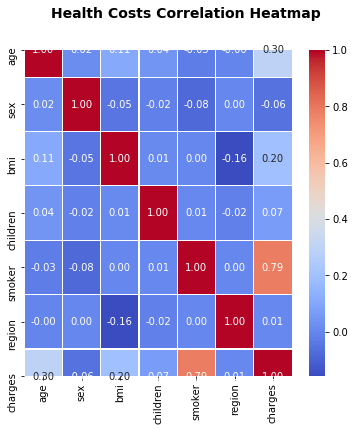

In [18]:
fig, (ax) = plt.subplots(1, 1, figsize=(6,6))

hm = sns.heatmap(Final_data.corr(), 
                 ax=ax, # Axes in which to draw the plot
                 cmap="coolwarm", # color-scheme
                 annot=True, 
                 fmt='.2f',       # formatting  to use when adding annotations.
                 linewidths=.05)

fig.suptitle('Health Costs Correlation Heatmap', 
              fontsize=14, 
              fontweight='bold');

### XGBoost

In [19]:
# Create X, y
X = DF_data.copy().drop(['charges'], axis=1)

y = DF_data.copy().charges

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

# XGBoost model:
XGB_model = XGBRegressor(random_state=0)
XGB_model.fit(train_X, train_y, verbose=False)

# make predictions
XGB_predictions = XGB_model.predict(val_X)
# Print MAE for initial XGB model
XGB_mae = mean_absolute_error(XGB_predictions, val_y)
print("Validation MAE for XGBoost Model : " + str(XGB_mae))

[20:33:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MAE for XGBoost Model : 2418.449732138223


C:\Users\Kerry\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### Slightly Tuned XGB Model

In [20]:
%%time

XGB_model = XGBRegressor(random_state=0)

parameters = {'learning_rate': [0.02, 0.025, 0.05, 0.075, 0.1], #so called `eta` value
              'max_depth': [2, 3, 4, 5],
             'n_estimators': [100, 150, 200, 250, 300, 500]}

XGB_grid = GridSearchCV(XGB_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

XGB_grid.fit(train_X, train_y)

print(XGB_grid.best_score_)
print(XGB_grid.best_params_)

# make predictions
XGB_grid_predictions = XGB_grid.predict(val_X)
# Print MAE for initial XGB model
XGB_grid_mae = mean_absolute_error(XGB_grid_predictions, val_y)
print("Validation MAE for grid search XGBoost Model : " + str(XGB_grid_mae))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   15.0s


[20:33:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8379747292477151
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Validation MAE for grid search XGBoost Model : 2441.206524885424
Wall time: 18.7 s


[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:   18.5s finished
C:\Users\Kerry\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


predicted medical charges are with mean average error of ~ 2400 for the XGBoost model. 
<br />
Tuning of the XGBoost model using gridsearchCV did not improve the mean absolute error.